# Web Scrapping: Tienda Online "Diario de una Cientítica"

Accedemos a una tienda online mediante 'BeautifulSoup' para crear un DataFrame que contiene información sobre los productos que se venden, precio, enlace, disponibilidad de stock y a la categoría que pertenecen dentro de la web.

También añadimos una visualización en la cual podemos observar cuántos productos hay por categoría en la tienda.

**Nota para Félix o Abel**

Tuve muchos problemas para scrapear los datos tanto de la web de Tesla como de otras. Al final utilicé esta web de compras; no tiene tablas pero he podido sacar suficientes datos para hacer el ejercicio.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = "https://diariodeunacientifica.com/categoria-producto/todos-los-productos/"


# Realizamos la solicitud a la página web y comprobamos si hemos tenido éxito
response = requests.get(url)
if response.status_code != 200:
   print("Error al acceder a la URL: {response}")

  
# Analizamos el HTML obtenido y buscamos todos los productos  
soup = BeautifulSoup(response.text, "html.parser")
web_data = [] #lista para almacenar todos los datos al final y crear el dataframe
products = soup.find_all('li', class_="product") 

# Iteramos sobre cada producto encontrado, extrayendo el nombre, la URL y el precio
for product in products:
    name = product.find('h2', class_="woocommerce-loop-product__title").text
    url_product = product.find('a')['href']
    price = product.find('span', class_= "price").text

# Dentro del mismo bucle, realizamos una segunda solicitud de la URL obtenida de cada producto para obtener más detalles y analizamos su HTML
    product_response = requests.get(url_product)
    if product_response.status_code != 200:
        continue  # Saltamos este producto si no se pudiera acceder al enlace

    product_soup = BeautifulSoup(product_response.text, "html.parser")

#  Extraemos la información sobre el estado de stock y las categorías a las que pertenece cada producto
    elements = product_soup.find('p', class_="stock in-stock")  

    if elements:
        stock_text = elements.text
    else:
        stock_text = "No disponible"

    category = product_soup.find('span', class_ = 'detail-content')

 # Creamos un diccionario con todos los datos y el respectivo df
    product_dict = {
        'Producto': name,
        'Precio': price,
        'URL': url_product,
        'Stock': stock_text,
        'Categoría': category.text
    }
    
    web_data.append(product_dict)

df = pd.DataFrame(web_data)


# Convertimos cada valor de la columna "Categoría" en columnas binarias utilizando get_dummies y las agregamos al df principal
categories = df['Categoría'].str.get_dummies(', ')
df = pd.concat([df, categories], axis=1)
df.drop(columns=['Todos los Productos','Categoría'], inplace=True) # Eliminamos las columnas redundantes o sin información

# Convertimos la columna de "Precio" a una numérica (más útil) eliminando el simbolo de la moneda
df['Precio'] = df['Precio'].str.replace('€', '')

# Función para estilizar hacia la izquierda el df
df_styled = df.style.set_properties(**{'text-align': 'center'})
df_styled

,Producto,Precio,URL,Stock,Hogar y Decoración,Moda y Complementos,Papelería,Regalos para cientific@s,San Valentin,Tazas
0,Bolso “Estampado Científico”,22.95,https://diariodeunacientifica.com/producto/bolso-estampado-cientifico/,Hay existencias (puede reservarse),0,1,0,1,1,0
1,Neceser “Estampado Científico”,14.95,https://diariodeunacientifica.com/producto/neceser-estampado-cientifico/,Hay existencias (puede reservarse),0,1,0,1,1,0
2,Agenda Científica “sin fechas”,17.95,https://diariodeunacientifica.com/producto/agenda-cientifica-sin-fechas/,No disponible,0,0,1,1,0,0
3,Taza Fight Like a Science Woman,11.95,https://diariodeunacientifica.com/producto/taza-fight-like-a-science-woman/,No disponible,1,0,0,0,0,1
4,Estuche “Estampado Científico”,12.95,https://diariodeunacientifica.com/producto/estuche-estampado-cientifico/,No disponible,0,0,1,1,0,0
5,Taza personalizada para Doctores y Doctoras,13.95,https://diariodeunacientifica.com/producto/taza-doctora-doctor/,No disponible,1,0,0,0,0,1
6,Memoria USB de 64 GB “Pipeta”,17.95,https://diariodeunacientifica.com/producto/usb-pipeta/,Hay existencias,0,0,1,1,0,0
7,Bolígrafo “Estampado Científico”,3.50,https://diariodeunacientifica.com/producto/boligrafo-estampado-cientifico/,Hay existencias,0,0,1,1,0,0
8,Taza “All you need is science”,11.95,https://diariodeunacientifica.com/producto/taza-all-you-need-is-science/,No disponible,1,0,0,0,0,1
9,Libro “UN VIRUS EN APUROS” – Lucía Almagro Ruz,17.95,https://diariodeunacientifica.com/producto/un-virus-en-apuros/,No disponible,0,0,1,1,0,0


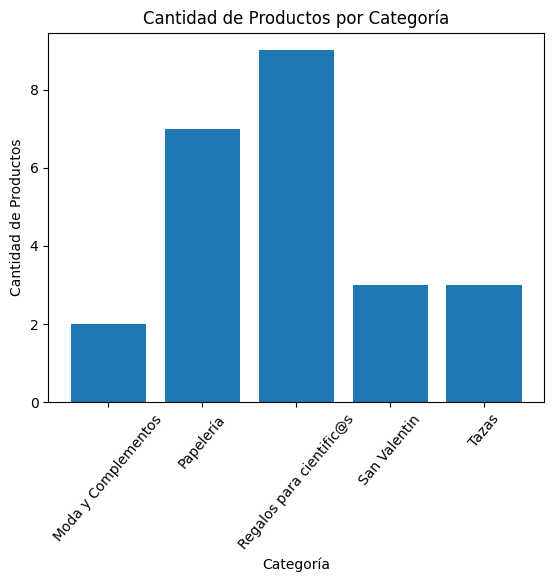

In [3]:

# Contamos la frecuencia de cada categoría y obtenemos los nombres de las mismas (columnas) utilizando index
category_counts = df.iloc[:, 5:].sum()
categories = category_counts.index

# Creamos el gráfico
plt.bar(categories, category_counts)

plt.xlabel('Categoría')
plt.ylabel('Cantidad de Productos')
plt.title('Cantidad de Productos por Categoría')
plt.xticks(rotation=50) #Rotar los nombres de las categorías para que quepan mejor
plt.show()